<a id='table_of_contents'></a>

0. [Import Packages](#imports_packages)  
1. [Import Data](#imports_data)
2. [Looking into the Data](#looking_data)
3. [Data Cleaning](#data_cleaning)
4. [Data Preparation](#data_preparation)
5. [Benchmark Model](#benchmark_model)  
    5.1. [Training Set Splitting](training_set_split)  
    5.2. [Fitting a Model](fitting_model)  
    5.3. [Evaluation of the Model](model_evaluation)  
6. [Feature Engineering](#feature_engineering)
7. [Model Training](#model_training)  
    7.1. [Decision Tree](#decision_tree)  
    7.2. [Random Forest](#random_forest)  
    7.3. [Gradient Boosting](#gradient_boosting)  
    7.4. [Comparison of Different Algorithm Performances](#comparing_performances)  
8. [Tuning](#model_tuning)  
    8.1. [Finding the Correct Hyper-Parameters](#hyper_parameters)  
9. [Seeing the Whole Thing as a Classification Problem](#classification_problem)  

# 0. Import Packages <a id='imports_packages'></a>
[Back to top](#table_of_contents)

In [150]:
import pandas as pd
import numpy as np

%matplotlib inline

# 1. Import Data <a id='imports_data'></a>
[Back to top](#table_of_contents)

In [151]:
taxi_jan_2019 = pd.read_csv('Data/yellow_tripdata_2019-01.csv')
taxi_data = pd.concat([taxi_jan_2019])

In [152]:
print(taxi_jan_2019.shape)
taxi_jan_2019.head()
#taxi_jan_2019_na.sort_values('passenger_count', ascending=False)

(7667792, 18)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


# 2. Looking into the Data <a id='looking_data'></a>
[Back to top](#table_of_contents)

In [153]:
taxi_jan_2019.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

In [154]:
taxi_data = taxi_data[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type',
       'total_amount']]

array([[<AxesSubplot:title={'center':'passenger_count'}>,
        <AxesSubplot:title={'center':'trip_distance'}>,
        <AxesSubplot:title={'center':'RatecodeID'}>],
       [<AxesSubplot:title={'center':'PULocationID'}>,
        <AxesSubplot:title={'center':'DOLocationID'}>,
        <AxesSubplot:title={'center':'payment_type'}>],
       [<AxesSubplot:title={'center':'total_amount'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

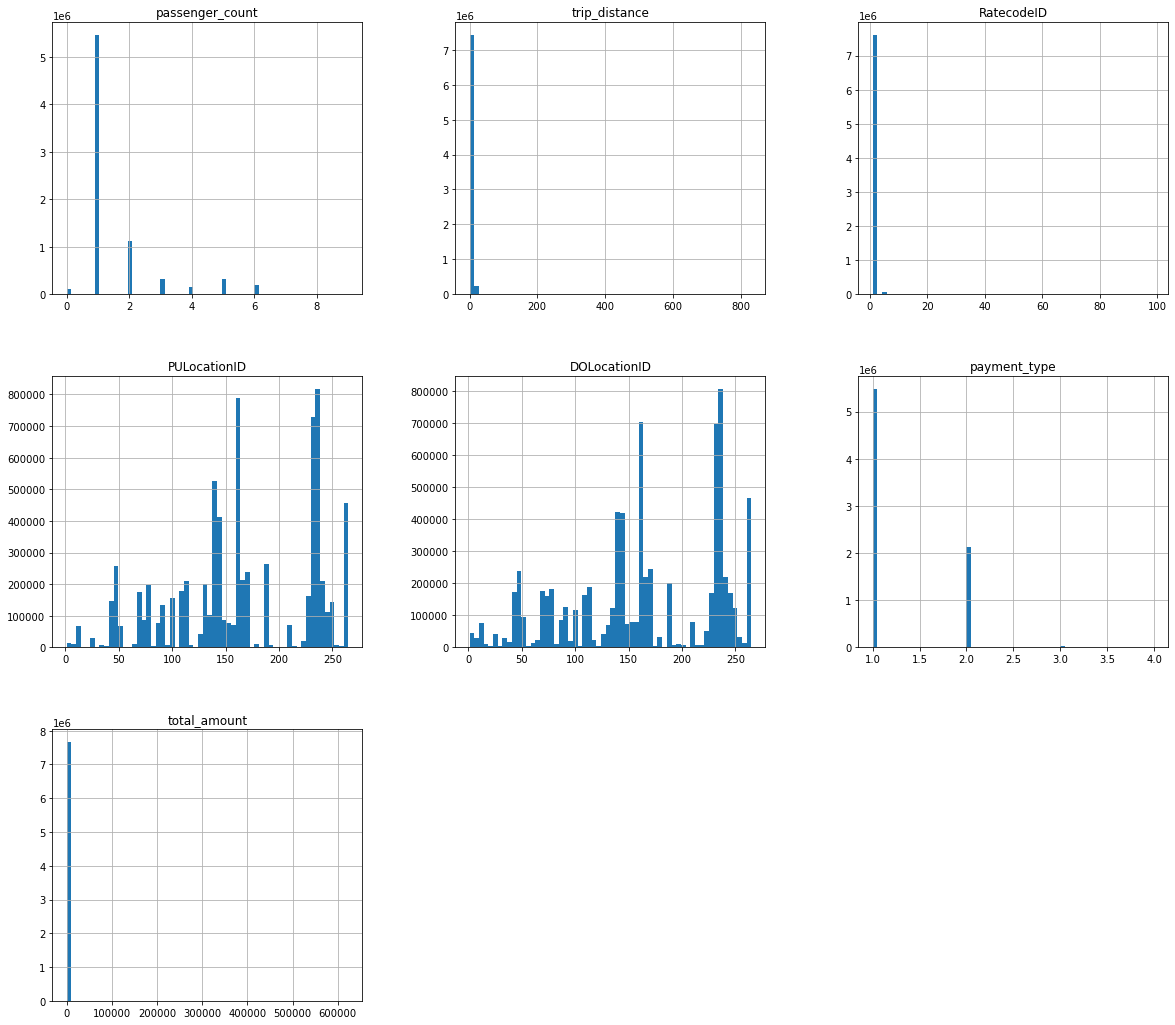

In [155]:
taxi_data.hist(figsize=(20,18), bins=60)

* <h2>Total Amount: </h2>

<AxesSubplot:xlabel='index', ylabel='total_amount'>

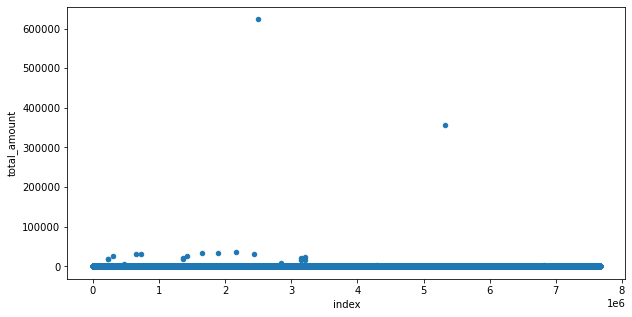

In [156]:
taxi_data['total_amount'].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

There are some outliers as seen above. They look odd comparing to other y values. Total_amount is surely a data column to be taken care of.

<AxesSubplot:xlabel='index', ylabel='total_amount'>

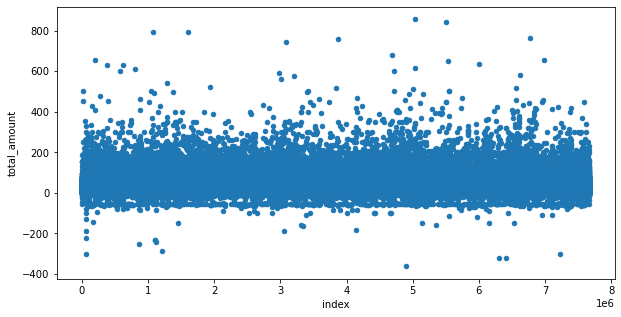

In [157]:
taxi_data[taxi_data['total_amount']<1000].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [158]:
taxi_data[taxi_data['total_amount']<0].head()
taxi_data[taxi_data['total_amount']<0].shape

(7131, 9)

There are values smaller than zero. Distance cannot negative so there are definetely some data that must be cleaned from the dataset. 

<AxesSubplot:xlabel='index', ylabel='total_amount'>

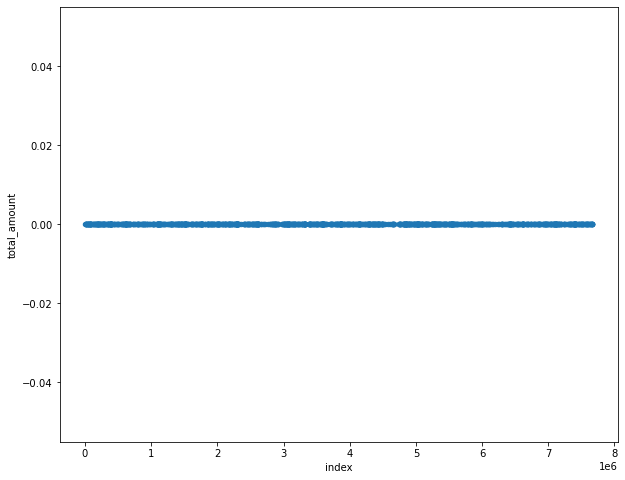

In [159]:
taxi_data[taxi_data['total_amount']==0].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,8))

In [160]:
taxi_data[taxi_data['total_amount']==0].head()
taxi_data[taxi_data['total_amount']==0].shape

(1414, 9)

There are also zero values in the column of total_amount. Paying 0 dollar for a taxi trip sounds also weird. Thus, three things to deal with:
1. Too high values (not known yet),
2. Negative values (7131 data points),
3. Zero values (1414 data points).

* <h2>Trip Distance: </h2>

<AxesSubplot:xlabel='index', ylabel='trip_distance'>

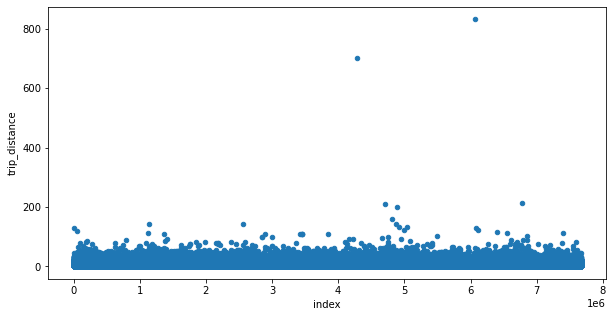

In [161]:
taxi_data['trip_distance'].reset_index().plot(kind='scatter', y='trip_distance', x='index', figsize=(10,5))

Trip distance is in miles so these outliers can be important to look at. 

* <h2>Payment Type: </h2>

<AxesSubplot:xlabel='index', ylabel='payment_type'>

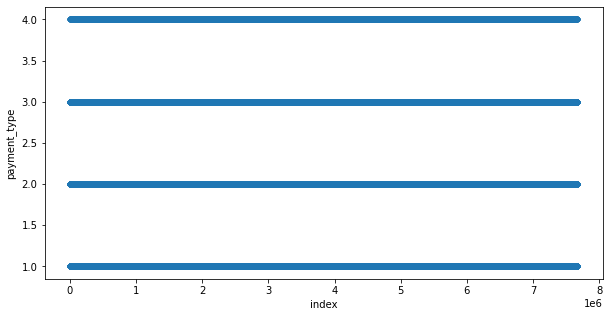

In [162]:
taxi_data['payment_type'].reset_index().plot(kind='scatter', y='payment_type', x='index', figsize=(10,5))

1. Credit card 
2. Cash
3. No charge 
4. Dispute

* <h2>More on Total Amount: </h2>

    Looking at the total_amount values smaller than 0:

<AxesSubplot:xlabel='index', ylabel='total_amount'>

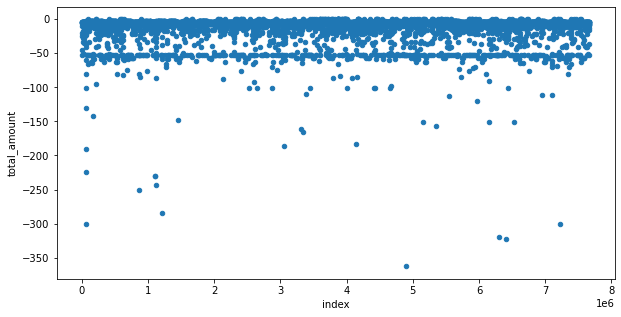

In [163]:
taxi_data[taxi_data['total_amount']<0].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [164]:
taxi_data[taxi_data['total_amount']<0].shape

(7131, 9)

In [165]:
taxi_data[taxi_data['total_amount']<0]['payment_type'].value_counts()

3    4088
4    2666
2     376
1       1
Name: payment_type, dtype: int64

In [166]:
taxi_data[taxi_data['total_amount']<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2,0.10,1,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1,4.13,1,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1,1.35,1,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1,0.00,1,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1,0.16,1,234,234,4,-4.3


Looking at the zero total_amount values:

Text(0.5, 0, 'distance (miles)')

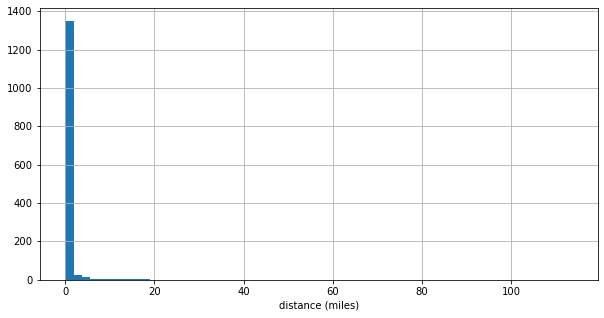

In [167]:
trip_hist = taxi_data[taxi_data['total_amount']==0]['trip_distance'].hist(bins=60, figsize=(10,5))
trip_hist.set_xlabel('distance (miles)')

It makes sense that zero-dollar-taxi-trips are for the distances = 0 which means no trip no payment.

In [168]:
taxi_data[(taxi_data['total_amount']==0) & (taxi_data['trip_distance']==0)].shape

(1270, 9)

In [169]:
taxi_data[(taxi_data['total_amount']>0) & (taxi_data['total_amount']<200) & (taxi_data['trip_distance']==0)].shape

(51696, 9)

51696 sounds like an important amount of data points to remove. Thus, I prefer expecting an explanation for the trips where trip_distance=0 and total_amount>0 instead of removing them.

Now, let's look at the very high total_amount values:

<AxesSubplot:xlabel='index', ylabel='total_amount'>

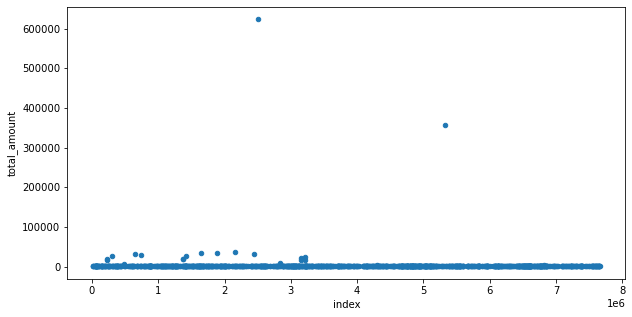

In [170]:
taxi_data[taxi_data['total_amount']>200].reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [171]:
print(taxi_data[taxi_data['total_amount']>100].shape)
print(taxi_data[taxi_data['total_amount']>200].shape)
print(taxi_data[taxi_data['total_amount']>300].shape)

#200 dollars seem like a reasonable cut-off value.

(10832, 9)
(1166, 9)
(307, 9)


# 3. Data Cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

Consider:
Negative, zero, and too high (>=200 dollars) total_amount values.

Assumption: Zero values are for mistaken trips. Those trips might be trips as such the taxi driver started the taximeter but then stopped right away for some reason (change of mind or any technical problem). Thus, I prefer removing those considering also 1414 data points are not a big deal for 7m dataset. 

In real life, I would ask the data owner about these zero values. However now I prefer making the assumption above.

In [172]:
taxi_data_cleaned = taxi_data[(taxi_data['total_amount']<200) & (taxi_data['total_amount']>0)]

In [173]:
print(taxi_data_cleaned.shape)
print(taxi_data.shape)

(7658076, 9)
(7667792, 9)


Let's check missing values once again whether there is any:

In [174]:
taxi_data_cleaned.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

# 4. Data Preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

In [175]:
taxi_data_cleaned.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
payment_type               int64
total_amount             float64
dtype: object

In [176]:
taxi_data_prepared = taxi_data_cleaned.copy() #deep copy

In [177]:
taxi_data_prepared.loc[:, 'tpep_pickup_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:, 'tpep_pickup_datetime'])
taxi_data_prepared.loc[:, 'tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:, 'tpep_dropoff_datetime'])

RatecodeID, PULocation, DOLocation, and payment_types are not numerical features. Thus, one would want them in strings instead of integers.

In [178]:
taxi_data_prepared.loc[:, 'RatecodeID'] = taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared.loc[:, 'PULocationID'] = taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared.loc[:, 'DOLocationID'] = taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared.loc[:, 'payment_type'] = taxi_data_prepared['payment_type'].astype(str)


In [179]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

In [180]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55


Getting month, day, time, and year information from the datetime:

In [181]:
taxi_data_prepared['transactionDate'] = pd.to_datetime(taxi_data_prepared['tpep_pickup_datetime']).dt.date
taxi_data_prepared['transactionMonth'] = taxi_data_prepared['tpep_pickup_datetime'].dt.month
taxi_data_prepared['transactionDay'] = taxi_data_prepared['tpep_pickup_datetime'].dt.day
taxi_data_prepared['transactionHour'] = taxi_data_prepared['tpep_pickup_datetime'].dt.hour
taxi_data_prepared['transactionYear'] = taxi_data_prepared['tpep_pickup_datetime'].dt.year

In [182]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transactionDate,transactionMonth,transactionDay,transactionHour,transactionYear
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95,2019-01-01,1,1,0,2019
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30,2019-01-01,1,1,0,2019
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80,2018-12-21,12,21,13,2018
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55,2018-11-28,11,28,15,2018
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55,2018-11-28,11,28,15,2018


Note that the data was downloaded for January 2019 but there is also year of 2018 above. Thus, it must be adjusted:

In [183]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transactionYear'] == 2019]
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transactionMonth'] == 1]

taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transactionDate,transactionMonth,transactionDay,transactionHour,transactionYear
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95,2019-01-01,1,1,0,2019
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30,2019-01-01,1,1,0,2019
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.3,1,163,229,1,9.05,2019-01-01,1,1,0,2019
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.7,1,229,7,1,18.50,2019-01-01,1,1,0,2019
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.1,1,141,234,1,13.00,2019-01-01,1,1,0,2019


In [184]:
#taxi_data_prepared.hist(figsize=(20, 10), bins = 60)

Which columns are needed for the modelling?

In [185]:
categorical_columns = ['PULocationID', 'transactionDate', 'transactionMonth', 'transactionDay', 'transactionHour']
numerical_columns = ['total_amount', 'trip_distance']

columns_needed = categorical_columns + numerical_columns
columns_needed

['PULocationID',
 'transactionDate',
 'transactionMonth',
 'transactionDay',
 'transactionHour',
 'total_amount',
 'trip_distance']

Including only the columns that are needed for modelling: 

(Note that the columns I am excluding below were kept by thinking that they might be helpful during data exploration, cleaning, and preparation.)

In [186]:
main_taxi_data = taxi_data_prepared[columns_needed]
main_taxi_data.head()

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance
0,151,2019-01-01,1,1,0,9.95,1.5
1,239,2019-01-01,1,1,0,16.30,2.6
7,163,2019-01-01,1,1,0,9.05,1.3
8,229,2019-01-01,1,1,0,18.50,3.7
9,141,2019-01-01,1,1,0,13.00,2.1


Since we are interested in the average income a taxi driver made in a specific region per hour, we should aggregate the data points considering total amount of money the driver made in a specific location, on a specific day, and at a specific hour:

In [187]:
taxi_groupedby_region = main_taxi_data.groupby(categorical_columns).mean().reset_index()
taxi_groupedby_region.head()

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance
0,1,2019-01-01,1,1,2,21.800,0.0
1,1,2019-01-01,1,1,5,87.300,0.0
2,1,2019-01-01,1,1,6,80.300,0.0
3,1,2019-01-01,1,1,8,128.580,0.0
4,1,2019-01-01,1,1,10,43.245,16.9


In [188]:
#taxi_groupedby_region['transactionHour'].value_counts() #hour-check whether all are unique. YES!

In [189]:
taxi_groupedby_region['transaction_amount'] = main_taxi_data.groupby(categorical_columns).count().reset_index()['total_amount']

In [190]:
taxi_groupedby_region.head()

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance,transaction_amount
0,1,2019-01-01,1,1,2,21.800,0.0,1
1,1,2019-01-01,1,1,5,87.300,0.0,1
2,1,2019-01-01,1,1,6,80.300,0.0,1
3,1,2019-01-01,1,1,8,128.580,0.0,2
4,1,2019-01-01,1,1,10,43.245,16.9,4


A quick check for 2019-01-01 10 AM:

In [191]:
main_taxi_data[(main_taxi_data['transactionHour']==10) & (main_taxi_data['PULocationID']=='1') & (main_taxi_data['transactionDay']==1)]

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance
79279,1,2019-01-01,1,1,10,3.30,16.9
79280,1,2019-01-01,1,1,10,16.56,16.9
79281,1,2019-01-01,1,1,10,16.56,16.9
79282,1,2019-01-01,1,1,10,136.56,16.9


array([[<AxesSubplot:title={'center':'transactionMonth'}>,
        <AxesSubplot:title={'center':'transactionDay'}>],
       [<AxesSubplot:title={'center':'transactionHour'}>,
        <AxesSubplot:title={'center':'total_amount'}>],
       [<AxesSubplot:title={'center':'trip_distance'}>,
        <AxesSubplot:title={'center':'transaction_amount'}>]],
      dtype=object)

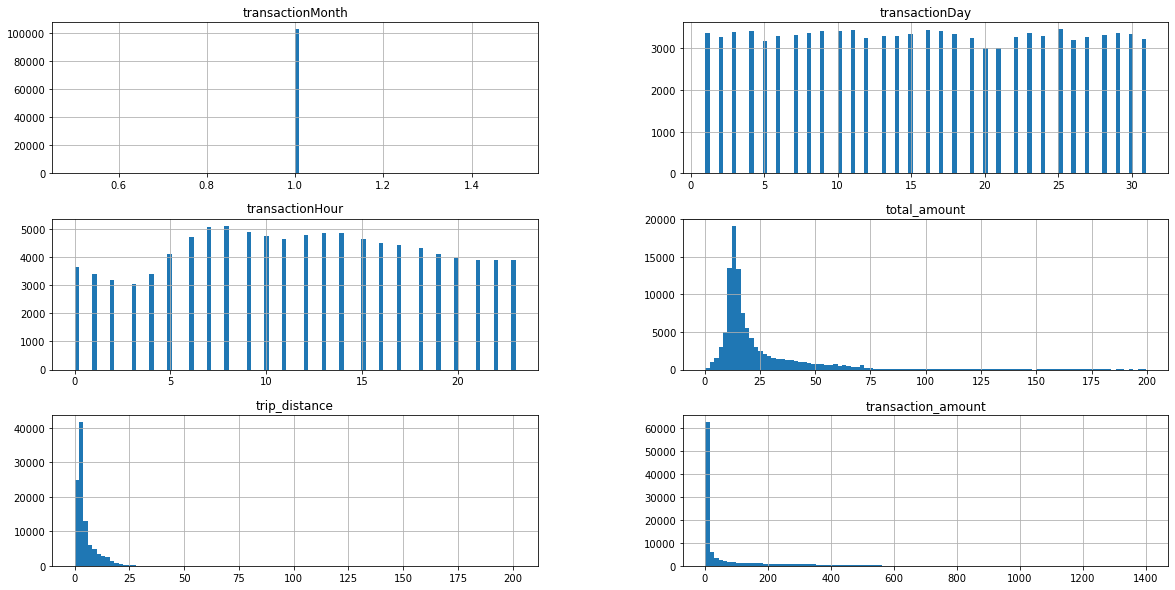

In [192]:
taxi_groupedby_region.hist(figsize=(20, 10), bins=100)

# 5. Benchmark Model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

- Which columns will be used as input feature?
- Which column(s) will be used as the target feature?
- Which columns will be used in the prediction?
    * See which columns contribute to the prediction.
    
Columns: PULocationID, transactionDate, transactionMonth, transactionDay, transactionHour, total_amount, trip_distance, transaction_amount

Target feature: total_amount (dollars per hour/date/region)
Input feature: transactionMonth, transactionDay, transactionHour, PULocationID

transactionDate --> this info is already included within transactionMonth, transactionDay, and transactionHour

transaction_amount --> refers to the number of transaction used while calculating total_amount per hour/date. Wouldn't contribute much to the prediction.

trip_distance --> may cause LEAKAGE because it is highly correlated with the target feature and knowing the distance that a driver in advance is not possible. Therefore, that column won't be used in the model training.

* Day and hour are circular features. They are included in categorical features for now while considering that each hour is distinct and there is no relationship between hours and days. Also, note that the dataset is only for January so for this project column of month will not be critical for the model. However, transactionMonth will be included for the future implementations.


In [193]:
data_benchmark_model = taxi_groupedby_region.copy()

In [194]:
target_feature_bm = 'total_amount'
categorical_features_bm = ['transactionMonth', 'transactionDay','transactionHour', 'PULocationID']
input_features_bm = categorical_features_bm

# 5.1 Training Set Splitting <a id='training_set_split'></a>
[Back to top](#table_of_contents)

In [195]:
from sklearn.model_selection import train_test_split

In [196]:
data_benchmark_model.dtypes

PULocationID           object
transactionDate        object
transactionMonth        int64
transactionDay          int64
transactionHour         int64
total_amount          float64
trip_distance         float64
transaction_amount      int64
dtype: object

In [197]:
x_benchmark = data_benchmark_model[input_features_bm]
y_benchmark = data_benchmark_model[target_feature_bm]

x_benchmark

,transactionMonth,transactionDay,transactionHour,PULocationID
0,1,1,2,1
1,1,1,5,1
2,1,1,6,1
3,1,1,8,1
4,1,1,10,1
...,...,...,...,...
102516,1,31,18,98
102517,1,18,18,99
102518,1,26,8,99
102519,1,30,7,99


In [198]:
#one-hot encoding for the categorical features that are strings (booelan columns)
x_benchmark = pd.get_dummies(x_benchmark)

x_train_bm, x_test_bm, y_train_bm, y_test_bm = train_test_split(x_benchmark, y_benchmark, test_size = 0.33, random_state = 42)


In [199]:
x_benchmark.shape

(102521, 266)

# 5.2 Fitting a Model <a id='fitting_model'></a>
[Back to top](#table_of_contents)

How do we decide the method? Why did we use Decision Tree for the model here? 

--> Depending on the problem and trial&error. 

--> Supervised/Unsupervised and Classification/Regression.

In [200]:
from sklearn.tree import DecisionTreeRegressor

In [201]:
tree = DecisionTreeRegressor(max_depth = 10) #tuning hyperparameters and finding the optimal values will be done later.
tree.fit(x_train_bm, y_train_bm)

DecisionTreeRegressor(max_depth=10)

# 5.3 Evaluation of the Model <a id='mode_evaluation'></a>
[Back to top](#table_of_contents)

How good is the model?

In [202]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [203]:
model_bm = tree
y_pred_bm = model_bm.predict(x_test_bm)

In [204]:
# evaluation metrics          

print('mean_absolute_error = ',  mean_absolute_error(y_test_bm, y_pred_bm ) )
print('mean_squared_error = ', mean_squared_error(y_test_bm, y_pred_bm))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_test_bm, y_pred_bm)))
print('r2 = ', r2_score(y_test_bm, y_pred_bm))

mean_absolute_error =  9.757872039086783
mean_squared_error =  216.18014986354686
root_mean_squared_error =  14.703066002148901
r2 =  0.21551953050308925


<AxesSubplot:xlabel='real', ylabel='predicted'>

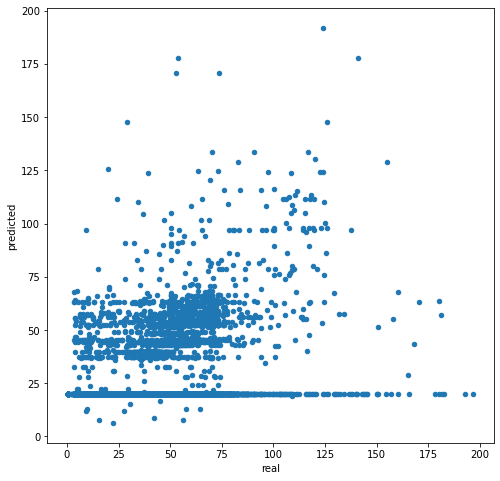

In [205]:
data = {'real': y_test_bm, 'predicted': y_pred_bm}
results = pd.DataFrame(data)

results.plot(figsize=(8, 8), kind='scatter', x='real', y='predicted')

# 6. Feature Engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)


In [206]:
taxi_data_new_features = taxi_groupedby_region.copy()

In [207]:
#delta = taxi_data_prepared['tpep_dropoff_datetime'] - taxi_data_prepared['tpep_pickup_datetime']
#delta
#taxi_data_prepared['tpep_duration'] = delta.dt.seconds/60

In [208]:
#delta.dtypes
taxi_data_new_features.head()

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance,transaction_amount
0,1,2019-01-01,1,1,2,21.800,0.0,1
1,1,2019-01-01,1,1,5,87.300,0.0,1
2,1,2019-01-01,1,1,6,80.300,0.0,1
3,1,2019-01-01,1,1,8,128.580,0.0,2
4,1,2019-01-01,1,1,10,43.245,16.9,4


* <h2> Data-related features </h2>
1) We can find the transaction days --> which days are more significant, holidays etc. from the date.

In [209]:
taxi_data_new_features['transaction_week_day'] = pd.to_datetime(taxi_data_new_features['transactionDate']).dt.weekday
taxi_data_new_features['weekend'] = taxi_data_new_features['transaction_week_day'].apply(lambda x: True if x==5 or x==6 else False)

In [210]:
taxi_data_new_features

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance,transaction_amount,transaction_week_day,weekend
0,1,2019-01-01,1,1,2,21.800,0.00,1,1,False
1,1,2019-01-01,1,1,5,87.300,0.00,1,1,False
2,1,2019-01-01,1,1,6,80.300,0.00,1,1,False
3,1,2019-01-01,1,1,8,128.580,0.00,2,1,False
4,1,2019-01-01,1,1,10,43.245,16.90,4,1,False
...,...,...,...,...,...,...,...,...,...,...
102516,98,2019-01-31,1,31,18,58.060,16.66,1,3,False
102517,99,2019-01-18,1,18,18,9.800,1.66,1,4,False
102518,99,2019-01-26,1,26,8,6.000,0.42,1,5,True
102519,99,2019-01-30,1,30,7,18.050,2.87,1,2,False


In [211]:
#now about calendar holidays
from pandas.tseries.holiday import USFederalHolidayCalendar

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start='2018', end='2020').date #.date converted the result into datetime object

taxi_data_new_features['holiday'] = taxi_data_new_features['transactionDate'].isin(holidays)

In [212]:
taxi_data_new_features

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance,transaction_amount,transaction_week_day,weekend,holiday
0,1,2019-01-01,1,1,2,21.800,0.00,1,1,False,True
1,1,2019-01-01,1,1,5,87.300,0.00,1,1,False,True
2,1,2019-01-01,1,1,6,80.300,0.00,1,1,False,True
3,1,2019-01-01,1,1,8,128.580,0.00,2,1,False,True
4,1,2019-01-01,1,1,10,43.245,16.90,4,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...
102516,98,2019-01-31,1,31,18,58.060,16.66,1,3,False,False
102517,99,2019-01-18,1,18,18,9.800,1.66,1,4,False,False
102518,99,2019-01-26,1,26,8,6.000,0.42,1,5,True,False
102519,99,2019-01-30,1,30,7,18.050,2.87,1,2,False,False


* <h2> Location Related Features </h2>

In [213]:
zone_lookup = pd.read_csv('data/taxi+_zone_lookup.csv')
zone_lookup = zone_lookup[['LocationID', 'Borough']]
zone_lookup['LocationID'] = zone_lookup['LocationID'].astype(str) #from int to object
zone_lookup.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [214]:
#extracting PULocation name information frim zone_lookup and adding this info as a column to taxi_data_new_features
taxi_data_new_features = taxi_data_new_features.merge(zone_lookup, left_on='PULocationID', right_on='LocationID', how='left')
taxi_data_new_features.head()

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance,transaction_amount,transaction_week_day,weekend,holiday,LocationID,Borough
0,1,2019-01-01,1,1,2,21.800,0.0,1,1,False,True,1,EWR
1,1,2019-01-01,1,1,5,87.300,0.0,1,1,False,True,1,EWR
2,1,2019-01-01,1,1,6,80.300,0.0,1,1,False,True,1,EWR
3,1,2019-01-01,1,1,8,128.580,0.0,2,1,False,True,1,EWR
4,1,2019-01-01,1,1,10,43.245,16.9,4,1,False,True,1,EWR


In [215]:
taxi_data_new_features.drop('LocationID', axis=1, inplace=True)
taxi_data_new_features.head()

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance,transaction_amount,transaction_week_day,weekend,holiday,Borough
0,1,2019-01-01,1,1,2,21.800,0.0,1,1,False,True,EWR
1,1,2019-01-01,1,1,5,87.300,0.0,1,1,False,True,EWR
2,1,2019-01-01,1,1,6,80.300,0.0,1,1,False,True,EWR
3,1,2019-01-01,1,1,8,128.580,0.0,2,1,False,True,EWR
4,1,2019-01-01,1,1,10,43.245,16.9,4,1,False,True,EWR


In [216]:
taxi_data_new_features['Borough'].value_counts()

Manhattan        45309
Brooklyn         23632
Queens           21971
Bronx             9584
Unknown           1453
Staten Island      302
EWR                270
Name: Borough, dtype: int64

* <h2> Weather Related Features </h2>

In [217]:
nyc_weather = pd.read_csv('DATA/nyc_weather.csv')

In [218]:
nyc_weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,31.12.2019 22:00,6.1,65,6,100%.,0.3
1,31.12.2019 19:00,6.7,71,5,70 – 80%.,NaN
2,31.12.2019 16:00,7.2,66,5,50%.,NaN
3,31.12.2019 13:00,6.1,76,3,100%.,Trace of precipitation
4,31.12.2019 10:00,4.4,83,2,100%.,Trace of precipitation


In [219]:
taxi_data_new_features.head()

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance,transaction_amount,transaction_week_day,weekend,holiday,Borough
0,1,2019-01-01,1,1,2,21.800,0.0,1,1,False,True,EWR
1,1,2019-01-01,1,1,5,87.300,0.0,1,1,False,True,EWR
2,1,2019-01-01,1,1,6,80.300,0.0,1,1,False,True,EWR
3,1,2019-01-01,1,1,8,128.580,0.0,2,1,False,True,EWR
4,1,2019-01-01,1,1,10,43.245,16.9,4,1,False,True,EWR


There are missing values. Also note that there are percentages that might not be easy to work with.

In [220]:
nyc_weather.dtypes

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                 object
amount of precipitation     object
dtype: object

We need date and time as datetime object.
We also should convert cloud cover percentages into floats as for amount of precipitation.

In [221]:
nyc_weather.loc[:, 'date and time'] = pd.to_datetime(nyc_weather.loc[:, 'date and time'])
nyc_weather['Month'] = nyc_weather['date and time'].dt.month
nyc_weather['Day'] = nyc_weather['date and time'].dt.day
nyc_weather['Hour'] = nyc_weather['date and time'].dt.hour

In [222]:
nyc_weather.dtypes

date and time              datetime64[ns]
temperature                       float64
humidity                            int64
wind speed                          int64
cloud cover                        object
amount of precipitation            object
Month                               int64
Day                                 int64
Hour                                int64
dtype: object

In [223]:
nyc_weather.isna().sum()

date and time                 0
temperature                   0
humidity                      0
wind speed                    0
cloud cover                   4
amount of precipitation    2240
Month                         0
Day                           0
Hour                          0
dtype: int64

In [224]:
nyc_weather['amount of precipitation'] = nyc_weather['amount of precipitation'].replace('Trace of precipitation', 0.1)
nyc_weather['amount of precipitation'] = nyc_weather['amount of precipitation'].astype(float)
nyc_weather['amount of precipitation'].interpolate(inpace=True) #the best practice
nyc_weather.isna().sum() 

date and time                 0
temperature                   0
humidity                      0
wind speed                    0
cloud cover                   4
amount of precipitation    2240
Month                         0
Day                           0
Hour                          0
dtype: int64

In [225]:
nyc_weather['cloud cover'].value_counts()

70 – 80%.                                                     973
100%.                                                         896
20–30%.                                                       479
50%.                                                          413
no clouds                                                     168
Sky obscured by fog and/or other meteorological phenomena.      3
Name: cloud cover, dtype: int64

In [226]:
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('70 – 80%.', 0.8)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('100%.', 1)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('20–30%.', 0.3)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('50%.', 0.5)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('no clouds', 0)
nyc_weather['cloud cover'] = nyc_weather['cloud cover'].replace('Sky obscured by fog and/or other meteorological phenomena.', 1)

nyc_weather['cloud cover'] = nyc_weather['cloud cover'].astype(float)



In [227]:
nyc_weather['cloud cover'].isna().sum()

4

In [228]:
nyc_weather['cloud cover'].interpolate(inplace=True)
nyc_weather['cloud cover'].isna().sum()

0

In [229]:
taxi_data_weather = taxi_data_new_features.merge(nyc_weather, left_on=['transactionMonth', 'transactionDay', 'transactionHour'], right_on=['Month', 'Day', 'Hour'], how='left')

In [230]:
taxi_data_weather = taxi_data_weather.drop(['Month', 'Day', 'Hour'], axis=1)
taxi_data_weather = taxi_data_weather.drop('date and time', axis=1)

In [231]:
taxi_data_weather.isna().sum()

PULocationID                   0
transactionDate                0
transactionMonth               0
transactionDay                 0
transactionHour                0
total_amount                   0
trip_distance                  0
transaction_amount             0
transaction_week_day           0
weekend                        0
holiday                        0
Borough                        0
temperature                68347
humidity                   68347
wind speed                 68347
cloud cover                68347
amount of precipitation    95994
dtype: int64

In [232]:
taxi_data_weather = taxi_data_weather.interpolate()
taxi_data_weather.isna().sum()

PULocationID                0
transactionDate             0
transactionMonth            0
transactionDay              0
transactionHour             0
total_amount                0
trip_distance               0
transaction_amount          0
transaction_week_day        0
weekend                     0
holiday                     0
Borough                     0
temperature                 4
humidity                    4
wind speed                  4
cloud cover                 4
amount of precipitation    29
dtype: int64

In [233]:
taxi_data_weather = taxi_data_weather.fillna(method='bfill') #backward filling
taxi_data_weather.isna().sum()

PULocationID               0
transactionDate            0
transactionMonth           0
transactionDay             0
transactionHour            0
total_amount               0
trip_distance              0
transaction_amount         0
transaction_week_day       0
weekend                    0
holiday                    0
Borough                    0
temperature                0
humidity                   0
wind speed                 0
cloud cover                0
amount of precipitation    0
dtype: int64

In [234]:
taxi_data_weather.head()

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance,transaction_amount,transaction_week_day,weekend,holiday,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,1,2019-01-01,1,1,2,21.800,0.0,1,1,False,True,EWR,15.6,62.0,11.0,0.8,0.3
1,1,2019-01-01,1,1,5,87.300,0.0,1,1,False,True,EWR,15.6,62.0,11.0,0.8,0.3
2,1,2019-01-01,1,1,6,80.300,0.0,1,1,False,True,EWR,15.6,62.0,11.0,0.8,0.3
3,1,2019-01-01,1,1,8,128.580,0.0,2,1,False,True,EWR,15.6,62.0,11.0,0.8,0.3
4,1,2019-01-01,1,1,10,43.245,16.9,4,1,False,True,EWR,15.6,62.0,11.0,0.8,0.3


# 7. Model Training <a id='model_training'></a>
[Back to top](#table_of_contents)

In [235]:
taxi_data_for_model = taxi_data_weather.copy()

In [236]:
taxi_data_weather.columns

Index(['PULocationID', 'transactionDate', 'transactionMonth', 'transactionDay',
       'transactionHour', 'total_amount', 'trip_distance',
       'transaction_amount', 'transaction_week_day', 'weekend', 'holiday',
       'Borough', 'temperature', 'humidity', 'wind speed', 'cloud cover',
       'amount of precipitation'],
      dtype='object')

In [237]:
categorical_features_bm

['transactionMonth', 'transactionDay', 'transactionHour', 'PULocationID']

In [238]:
categorical_features_mt = ['transactionMonth', 'transactionDay', 'transactionHour', 'PULocationID', 'transaction_week_day', 'weekend', 'holiday', 'Borough']
input_features_mt = categorical_features_mt + ['temperature', 'humidity', 'wind speed', 'cloud cover', 'amount of precipitation']
target_feature = 'total_amount'

* <h2> Splitting Train&Test Dataset </h2>

In [239]:
from sklearn.model_selection import train_test_split

x = taxi_data_for_model[input_features_mt]
y = taxi_data_for_model[target_feature]

#one-hot encoding for the categorical features that are strings (booelan columns)
x = pd.get_dummies(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)



<h2> 7.1. Decision Tree  <a id='decision_tree'></a> </h2>

[Back to top](#table_of_contents)

In [240]:
decision_tree = DecisionTreeRegressor(max_depth=10) 
decision_tree.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [241]:
recent_model = decision_tree
y_pred_dt = recent_model.predict(x_test)

mean_absolute_error =  8.458530324532672
mean_squared_error =  191.71328939414573
root_mean_squared_error =  13.846056817525549
r2 =  0.30430554624165873


<AxesSubplot:xlabel='real', ylabel='predicted'>

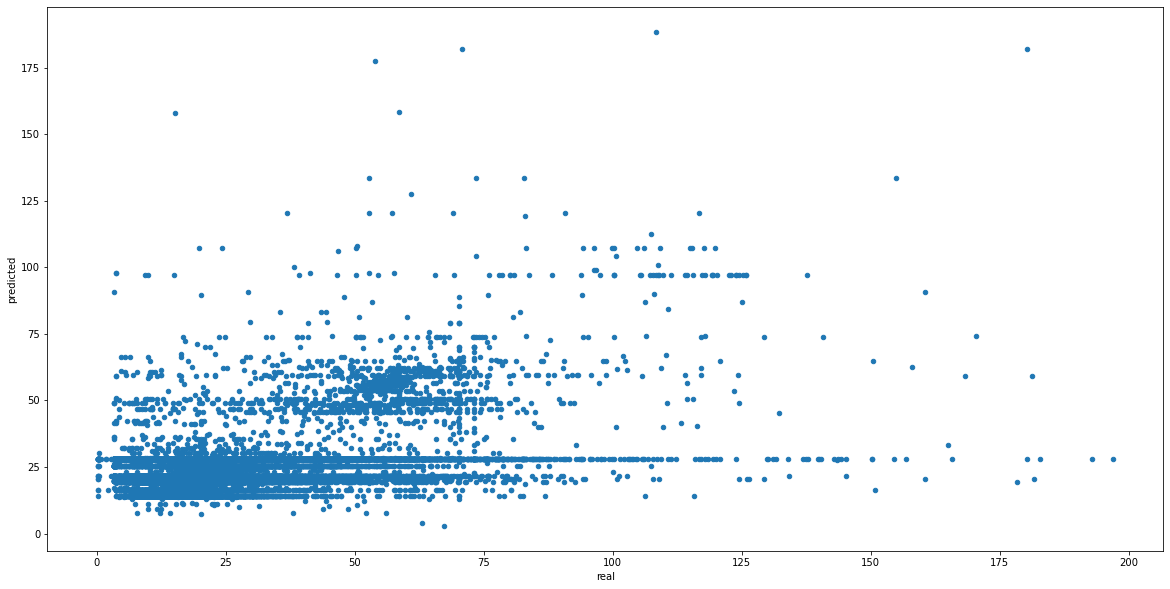

In [242]:
# evaluation metrics
print('mean_absolute_error = ',  mean_absolute_error(y_test, y_pred_dt ) )
print('mean_squared_error = ', mean_squared_error(y_test, y_pred_dt))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_test, y_pred_dt)))
print('r2 = ', r2_score(y_test, y_pred_dt))


data_dt = {'real': y_test, 'predicted': y_pred_dt}
results_dt = pd.DataFrame(data_dt)

results_dt.plot(figsize=(20, 10), kind='scatter', x='real', y='predicted')

In [243]:
# evaluation metrics from benchmark
print('mean_absolute_error = ',  mean_absolute_error(y_test_bm, y_pred_bm ) )
print('mean_squared_error = ', mean_squared_error(y_test_bm, y_pred_bm))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_test_bm, y_pred_bm)))
print('r2 = ', r2_score(y_test_bm, y_pred_bm))

mean_absolute_error =  9.757872039086783
mean_squared_error =  216.18014986354686
root_mean_squared_error =  14.703066002148901
r2 =  0.21551953050308925


* Trying different max_depth values to see if the model will get better.

<h3> Overfitting</h3>

In [244]:
x_train_overfit = x_train
y_train_overfit = y_train
x_test_overfit = x_test
y_test_overfit = y_test

rmse_scores = {'rmse_train': [], 'rmse_test': [], 'max_depth': []}

for i in [2, 5, 8, 10, 15, 20, 30, 50, 70, 100, 120, 150]:
    print(i) #max_depth value
    decision_tree_overfit = DecisionTreeRegressor(max_depth=i) 
    decision_tree_overfit.fit(x_train_overfit, y_train_overfit)

    recent_model_overfit = decision_tree_overfit
    
    y_pred_train = recent_model_overfit.predict(x_train_overfit)
    rmse_train = sqrt(mean_squared_error(y_train_overfit, y_pred_train))


    y_pred_test = recent_model_overfit.predict(x_test_overfit)
    rmse_test = sqrt(mean_squared_error(y_test_overfit, y_pred_test))

    rmse_scores['rmse_train'].append(rmse_train)
    rmse_scores['rmse_test'].append(rmse_test)
    rmse_scores['max_depth'].append(i)

2
5
8
10
15
20
30
50
70
100
120
150


In [245]:
pd.DataFrame.from_dict(rmse_scores)

,rmse_train,rmse_test,max_depth
0,1.500713e+01,15.011036,2
1,1.420570e+01,14.276538,5
2,1.361281e+01,13.896398,8
3,1.323228e+01,13.850625,10
4,1.205282e+01,14.064202,15
5,1.105102e+01,14.379622,20
6,9.473315e+00,14.971949,30
7,5.177598e+00,16.645059,50
8,9.951931e-01,17.326127,70
9,6.767168e-17,17.347388,100


Text(0, 0.5, 'root mean squared error')

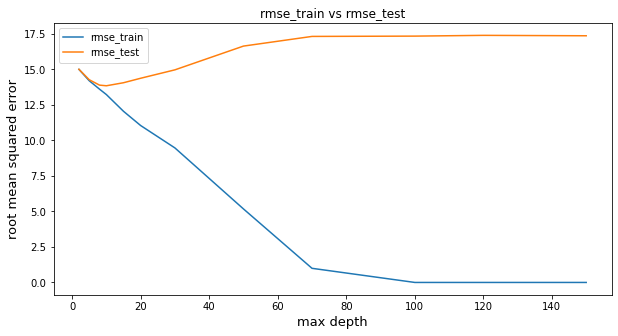

In [246]:
ax = pd.DataFrame.from_dict(rmse_scores).plot(figsize=[10, 5], x='max_depth', title='rmse_train vs rmse_test')
ax.set_xlabel("max depth", fontsize=13)
ax.set_ylabel("root mean squared error", fontsize=13)

Since the model overfits the data, the error on the test dataset increases with the increase in the max depth as the model loses its ability to generalize on the new data points that it sees, so called the test data points. Actually from this test, we can see which max_depth to use for our model. max_depth=10 was a good choice since the error starts increasing after that value.


<h3> Underfitting</h3>

- When the model is not complex enough to learn from the train set.

In [247]:
x_train_ufit = x_train
y_train_ufit = y_train
x_test_ufit = x_test
y_test_ufit = y_test

decision_tree_underfit = DecisionTreeRegressor(max_depth=1) 
decision_tree_underfit.fit(x_train_ufit, y_train_ufit)

recent_model_ufit = decision_tree_underfit


#training
y_pred_underfit = recent_model_ufit.predict(x_train_ufit) #training dataset is used for the prediction.

print('mean_absolute_error = ',  mean_absolute_error(y_train_ufit, y_pred_underfit))
print('mean_squared_error = ', mean_squared_error(y_train_ufit, y_pred_underfit))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_train_ufit, y_pred_underfit)))
print('r2 = ', r2_score(y_train_ufit, y_pred_underfit))


mean_absolute_error =  9.985020797900491
mean_squared_error =  242.2788107422694
root_mean_squared_error =  15.565307923143358
r2 =  0.12390453655791434


Even for the training dataset, prediction is not great.

<h2> 7.2. Random Forest  <a id='random_forest'></a> </h2>

[Back to top](#table_of_contents)

In [249]:
from sklearn.ensemble import RandomForestRegressor 

random_forest_model = RandomForestRegressor() 
random_forest_model.fit(x_train, y_train)

recent_model = random_forest_model
y_pred_rf = recent_model.predict(x_test)

mean_absolute_error =  7.368030214120481
mean_squared_error =  170.0651575046808
root_mean_squared_error =  13.040903247270904
r2 =  0.38286288223711396


<AxesSubplot:xlabel='real', ylabel='predicted'>

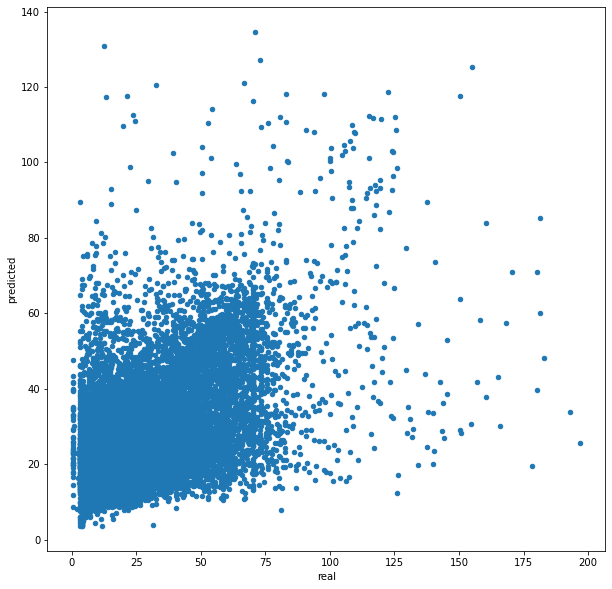

In [250]:
# evaluation metrics
print('mean_absolute_error = ',  mean_absolute_error(y_test, y_pred_rf) )
print('mean_squared_error = ', mean_squared_error(y_test, y_pred_rf))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_test, y_pred_rf)))
print('r2 = ', r2_score(y_test, y_pred_rf))


data_rf = {'real': y_test, 'predicted': y_pred_rf}
results_rf = pd.DataFrame(data_rf)

results_rf.plot(figsize=(10, 10), kind='scatter', x='real', y='predicted')

<h2> 7.3. Gradient Boosting  <a id='gradient_boosting'></a> </h2>

[Back to top](#table_of_contents)

In [251]:
from sklearn.ensemble import GradientBoostingRegressor

gradientBoost_model = GradientBoostingRegressor() 
gradientBoost_model.fit(x_train, y_train)

recent_model = gradientBoost_model
y_pred_gb = recent_model.predict(x_test)

mean_absolute_error =  8.336224718788552
mean_squared_error =  174.79657810666862
root_mean_squared_error =  13.221065694817064
r2 =  0.36569337311438654


<AxesSubplot:xlabel='real', ylabel='predicted'>

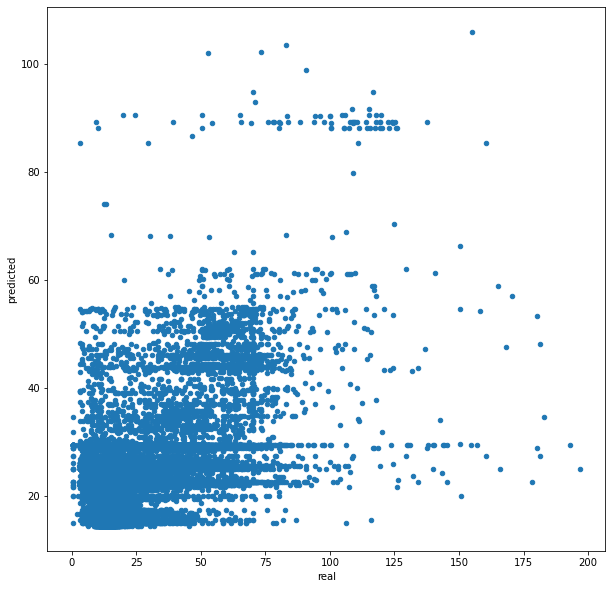

In [252]:
# evaluation metrics
print('mean_absolute_error = ',  mean_absolute_error(y_test, y_pred_gb))
print('mean_squared_error = ', mean_squared_error(y_test, y_pred_gb))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_test, y_pred_gb)))
print('r2 = ', r2_score(y_test, y_pred_gb))


data_gb = {'real': y_test, 'predicted': y_pred_gb}
results_gb = pd.DataFrame(data_gb)

results_gb.plot(figsize=(10, 10), kind='scatter', x='real', y='predicted')

What feature works the most towards predicting the target_feature?

<AxesSubplot:>

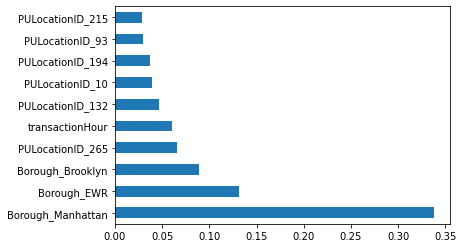

In [253]:
(pd.Series(decision_tree.feature_importances_, index=x_train.columns)
   .nlargest(10)
   .plot(kind='barh'))

<AxesSubplot:>

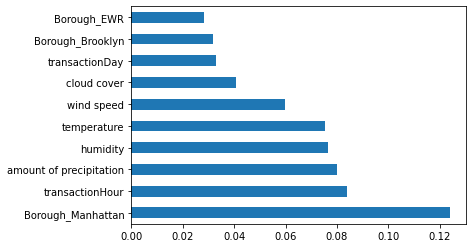

In [254]:
(pd.Series(random_forest_model.feature_importances_, index=x_train.columns)
   .nlargest(10)
   .plot(kind='barh'))

<AxesSubplot:>

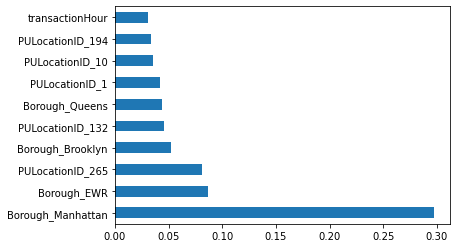

In [255]:
(pd.Series(gradientBoost_model.feature_importances_, index=x_train.columns)
   .nlargest(10)
   .plot(kind='barh'))

<h2> 7.4. Comparison of Different Algorithm Performances  <a id='comparing_performances'></a> </h2>

[Back to top](#table_of_contents)

In [256]:
mae_bm = mean_absolute_error(y_test_bm, y_pred_bm )
rmse_bm = sqrt(mean_squared_error(y_test_bm, y_pred_bm))
r2_bm = r2_score(y_test_bm, y_pred_bm)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

comparison = {'Algorithm':['Benchmark', 'Decision Tree', 'Random Forest', 'Gradient Boosting'], 'MAE':[mae_bm, mae_dt, mae_rf, mae_gb], 'RMSE':[rmse_bm, rmse_dt, rmse_rf, rmse_gb], 
              'R2':[r2_bm, r2_dt, r2_rf, r2_gb]} 

In [257]:
pd.DataFrame.from_dict(comparison)

,Algorithm,MAE,RMSE,R2
0,Benchmark,9.757872,14.703066,0.215520
1,Decision Tree,8.458530,13.846057,0.304306
2,Random Forest,7.368030,13.040903,0.382863
3,Gradient Boosting,8.336225,13.221066,0.365693


The model fitted using Random Forest algorithm will be worked on in the next sections. Correct hyper-parameters will be tuned to improve the model performance.

# 8. Tuning <a id='model_tuning'></a>
[Back to top](#table_of_contents)

<h2> 8.1. Finding the Correct Hyper-Parameters  <a id='hyper_parameters'></a> </h2>

[Back to top](#table_of_contents)


In [258]:
# class sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, 
#     criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#     min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
#     bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, 
#     max_samples=None)




In [259]:
# Maximum numbr of levels in tree
max_depth = [10, 20, 50, 70, 100, 200, 300, 500]
max_depth.append(None)

#The minimum number of samples required to be at a leaf node
min_samples_leaf = [1, 2, 4, 8, 10, 20, 30]

#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30, 40]

#The number of features to consider when looking for the best split
max_features = ['auto', 'sqrt']

#If False, the whole dataset is used to build each tree.
bootstrap = [True, False]

#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]



Above is our options however trying them all would be lots of calculations. Thus, we will choose random combinations and train our models.

In [260]:
#np.linspace(start=100, stop=1000, num=5)
# array([ 100.,  325.,  550.,  775., 1000.])

In [261]:
import pprint as pp

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pp.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 50, 70, 100, 200, 300, 500, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 10, 20, 30],
 'min_samples_split': [2, 5, 10, 20, 30, 40],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [262]:
from sklearn.model_selection import RandomizedSearchCV

#uses random_grid to search for the best hyper-parameters

#rf = RandomForestRegressor()

#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, cv=3, 
#                              verbose=2, random_state=42, n_jobs=-1)

cv=3 --> 3-fold cross-validation
k-fold cross-validation helps us validate that our model is stable. Divides the data into 3 chunks and compares performances for each. 

n_iter=10 --> RandomizerdSearchCV will come up with 10 difference random combinations of the random_grid.

n_jobs=-1 --> Using all processors.

verbose=2 --> Controls the verbosity: the higher, the more messages.

In [263]:
# Fit the random search model
#rf_random.fit(x_train, y_train)
#performances = pd.DataFrame.from_dict(rf_random.cv_results_).to_csv("comparison_performances.csv")
#performances.head()

In [270]:
performances = pd.read_csv('comparison_performances.csv')
performances.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0,35.850681,0.169700,1.698198,0.011166,200,5,4,sqrt,NaN,True,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.418840,0.419511,0.420490,0.419613,0.000677,2
1,1,132.787684,0.544915,1.111834,0.045422,200,10,1,auto,20.0,True,"{'n_estimators': 200, 'min_samples_split': 10,...",0.381828,0.389408,0.392572,0.387936,0.004508,7
2,2,174.376435,6.070378,1.467499,0.104816,200,40,20,auto,300.0,True,"{'n_estimators': 200, 'min_samples_split': 40,...",0.417801,0.415922,0.417587,0.417103,0.000840,3
3,3,258.236135,1.954857,7.888360,0.230898,1800,20,30,sqrt,300.0,False,"{'n_estimators': 1800, 'min_samples_split': 20...",0.394482,0.392790,0.392142,0.393138,0.000986,6
4,4,1950.955563,13.417053,3.067879,0.018001,400,20,4,auto,300.0,True,"{'n_estimators': 400, 'min_samples_split': 20,...",0.418657,0.420630,0.423552,0.420946,0.002011,1


In [ ]:
#rf_random.best_params_

In [272]:
import time
t0 = time.time()

model_with_best_params = RandomForestRegressor(n_estimators= 400,
 min_samples_split= 20,
 min_samples_leaf= 4,
 max_features= 'auto',
 max_depth= 300,
 n_jobs = -1,                                              
 bootstrap= True)

model_with_best_params.fit(x_train, y_train)



RandomForestRegressor(max_depth=300, min_samples_leaf=4, min_samples_split=20,
                      n_estimators=400, n_jobs=-1)

In [279]:
recent_model = model_with_best_params

y_pred = recent_model.predict(x_test)

In [285]:
t1 = time.time() - t0
print("Time elapsed: ", t1, " seconds")

# evaluation metrics
print('mean_absolute_error = ',  mean_absolute_error(y_test, y_pred))
print('mean_squared_error = ', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_test, y_pred)))
print('r2 = ', r2_score(y_test, y_pred))



Time elapsed:  458.07429814338684  seconds
mean_absolute_error =  7.1547900841284005
mean_squared_error =  157.58722540002626
root_mean_squared_error =  12.55337506011934
r2 =  0.4281431452121771


<AxesSubplot:xlabel='real', ylabel='predicted'>

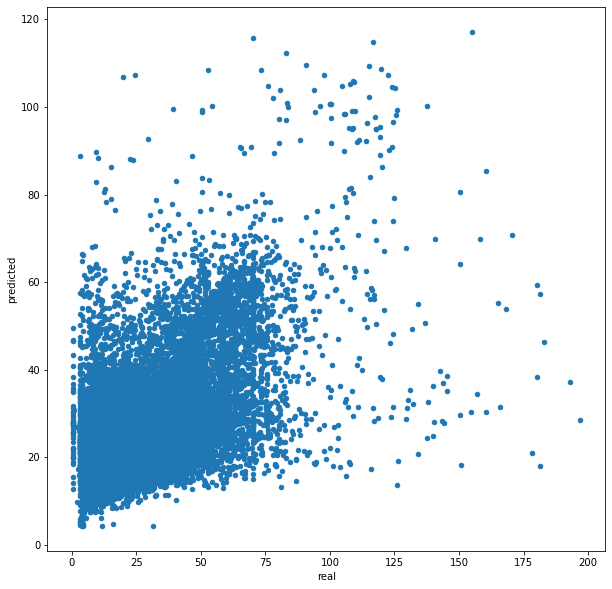

In [284]:
data = {'real': y_test, 'predicted': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(10, 10), kind='scatter', x='real', y='predicted')

# 9. Seeing the Whole Thing as a Classification Problem <a id='classification_problem'></a>
[Back to top](#table_of_contents)

Let's say that we are trying to classify the NY region as low and high income regions for the taxi drivers:

<AxesSubplot:>

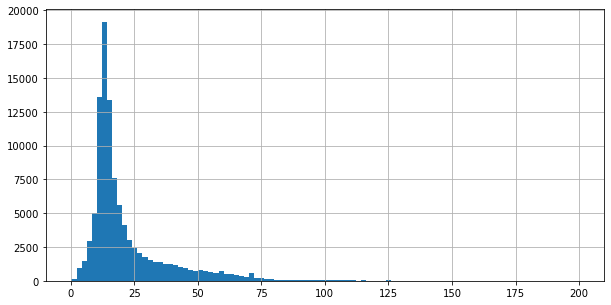

In [286]:
taxi_data_weather['total_amount'].hist(bins=100, figsize=(10, 5))

Anything less than 15 dollars will be regarded as low income.

In [287]:
nyc_class = taxi_data_weather.copy()
nyc_class['earning_class']=nyc_class['total_amount'].apply(lambda x: 'low' if x<=15 else 'high')
nyc_class['earning_class_binary']=nyc_class['earning_class'].apply(lambda x: 0 if x=='low' else 1)
nyc_class.head()

,PULocationID,transactionDate,transactionMonth,transactionDay,transactionHour,total_amount,trip_distance,transaction_amount,transaction_week_day,weekend,holiday,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation,earning_class,earning_class_binary
0,1,2019-01-01,1,1,2,21.800,0.0,1,1,False,True,EWR,15.6,62.0,11.0,0.8,0.3,high,1
1,1,2019-01-01,1,1,5,87.300,0.0,1,1,False,True,EWR,15.6,62.0,11.0,0.8,0.3,high,1
2,1,2019-01-01,1,1,6,80.300,0.0,1,1,False,True,EWR,15.6,62.0,11.0,0.8,0.3,high,1
3,1,2019-01-01,1,1,8,128.580,0.0,2,1,False,True,EWR,15.6,62.0,11.0,0.8,0.3,high,1
4,1,2019-01-01,1,1,10,43.245,16.9,4,1,False,True,EWR,15.6,62.0,11.0,0.8,0.3,high,1


In [288]:
nyc_class['earning_class'].value_counts()

high    53166
low     49355
Name: earning_class, dtype: int64

In [289]:
categorical_features = ['transactionMonth', 'transactionDay', 'transactionHour', 'PULocationID', 'transaction_week_day', 'weekend', 'holiday', 'Borough']
input_features = categorical_features_mt + ['temperature', 'humidity', 'wind speed', 'cloud cover', 'amount of precipitation']
target_feature = 'earning_class_binary'

In [290]:
from sklearn.model_selection import train_test_split

x_c = nyc_class[input_features]
y_c = nyc_class[target_feature]

#one-hot coding
x_c = pd.get_dummies(x_c)

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x_c, y_c, test_size=0.33, random_state=42)

In [291]:
from sklearn.ensemble import RandomForestClassifier

clsf = RandomForestClassifier()
clsf.fit(x_train_c, y_train_c)

y_pred_c = clsf.predict(x_test_c)

In [292]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from math import sqrt

print(confusion_matrix(y_test_c, y_pred_c))

print('accuracy', accuracy_score(y_test_c, y_pred_c))
print('precision', precision_score(y_test_c, y_pred_c))
print('recall', recall_score(y_test_c, y_pred_c))

[[11465  4654]
 [ 3876 13837]]
accuracy 0.7478718373137858
precision 0.7483099886431237
recall 0.7811776661209281


<AxesSubplot:>

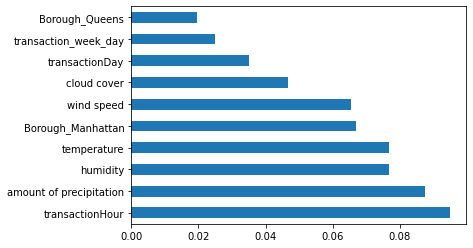

In [293]:
(pd.Series(clsf.feature_importances_, index=x_train.columns)
   .nlargest(10)
   .plot(kind='barh'))